In [1]:
import pandas as pd
import numpy as np
import rasterio
import geopandas as gpd
import os
import xarray as xr
import pyproj
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import re
import glob
from shapely.geometry import mapping

<Axes: >

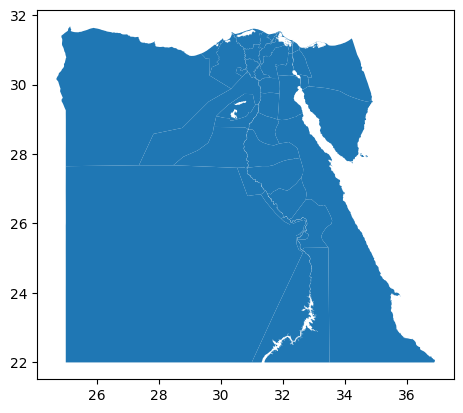

In [2]:
shapeFilePath = '../EgypeShapeFile/egy_admbnda_adm1_capmas_20170421'
nuts = gpd.read_file('../EgypeShapeFile/egy_admbnda_adm1_capmas_20170421.shp')
nuts = nuts.set_index('ADM1_EN')
nuts.plot()

In [48]:
minLon= 23.0; minLat= 21.0; maxLon= 37; maxLat= 36.0
#bbox = [minLon, minLat, maxLon, maxLat]
def cut_to_bbox(ds, minLon=minLon, minLat=minLat, maxLon=maxLon, maxLat=maxLat):
    ds = ds.sel(rlon=slice(minLon, maxLon), rlat=slice(minLat, maxLat))
    return ds
    
def cut_to_region(ds):
    ds = ds.rio.clip(nuts.geometry.apply(mapping), nuts.crs)
    return ds

In [49]:
files =  'outputAgriculture_workflow\\data\\tasmax_AFR-22_CCCma-CanESM2_rcp45_r1i1p1_CCCma-CanRCM4_r2_day_20260101-20301231.nc'

ds_tasmax = xr.open_mfdataset(f'{files}', decode_coords='all',
                                     preprocess=cut_to_bbox)    ####################################
Tmax=ds_tasmax['tasmax'].convert_calendar('noleap').groupby('time.dayofyear').mean().to_numpy()-273.15

lons=ds_tasmax['lon']
lats=ds_tasmax['lat']
lons=lons.to_numpy().reshape((-1,1))
lats=lats.to_numpy().reshape((-1,1))
coords_11=np.hstack((lons,lats))

In [55]:
raster_path = '202505300800.tif'
dff=pd.DataFrame() 

with rasterio.open(raster_path) as src:
    dff['cl'] = [x[0] for x in src.sample(coords_11)]  
cl=dff['cl'].to_numpy(dtype='float64').reshape(len(Tmax[0,:,0]),len(Tmax[0,0,:]))
cl[cl<0]=0

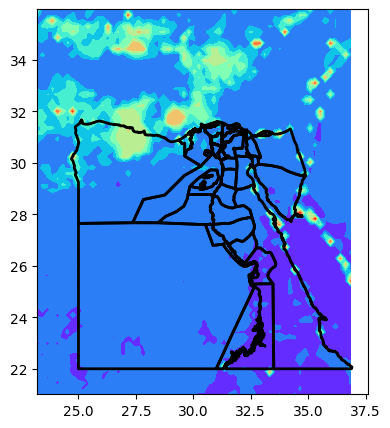

In [56]:
## AWC
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

lon_plot=ds_tasmax['lon'].to_numpy()
lat_plot=ds_tasmax['lat'][:].to_numpy()

p = ax.contourf(lon_plot,lat_plot,cl,cmap='rainbow',zorder=1)
nuts.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=2)

#cbar = fig.colorbar(p, ax=ax)
plt.savefig('202505300800.png')
